# The Variational Quantum Eigensolver algorithm

## Table of content
1. [VQE in Qiskit](#qiskit)
    1. [General overview](#gen)
    2. [Optimizer](#opt)
    3. [Variational form or ansatz](#ansatz)
    4. [Hamiltonian](#qubitop)
    5. [Quantum instance](#inst)
2. [Simple example over one qubit](#qubit)
3. [The Max-Cut problem](#maxcut)



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.axes as axes
from numpy import cos, sin, pi

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators.operator_globals import Z
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.tools.visualization import plot_histogram

from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2, ExcitationPreserving, ZGate

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [2]:
# Loading your IBM Q account
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q', group='open', project = 'main')

## 1 - VQE in Qiskit <a name = 'qiskit'></a>

### 1.1 - General overview <a name = 'gen'></a>

The **Variational Quantum Eigensolver** (VQE) is a hybrid algorithm based on the *variational principle of quantum mechanics* that uses a variational technique to find the minimum eigenvalue of the *hamiltonian* $H$ of the studied system.


<img src="vqetot.png" width = "700"/>



In addition to the studied hamiltonian, an instance of VQE will require two other components: the *ansatz* and the *optimizer*. See later for their specific definition in Qiskit.

Then, in order to run the algorithm, a *quantum instance*, or simply a *backend*, will be specified. There are two ways to specify it: either directly in the VQE instance or in the run method when running the instance.

Other components can be passed for the VQE instance:

    vqe = VQE(operator=None, var_form=None, optimizer=None,
    initial_point=None, expectation=None, max_evals_grouped=1,
    aux_operators=None, callback=None, quantum_instance=None)
    
See details of implementation [here](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html).

> Remark : it is possible to compare the solution from the VQE instance with the exact solution by using this function :   
    `from qiskit.aqua.algorithm import NumPyEigensolver`  
    `exact = NumPyEigensolver(qubitOp)`  
    `result_exact = exact.run()`

- `operator` (`Union[OperatorBase, LegacyBaseOperator, None]`) – Qubit operator of the Observable

- `var_form` (`Union[QuantumCircuit, VariationalForm, None]`) – A parameterized circuit used as Ansatz for the wave function.

- `optimizer` (`Optional[Optimizer]`) – A classical optimizer.

- `initial_point` (`Optional[ndarray]`) – An optional initial point (i.e. initial parameter values) for the optimizer. If None then VQE will look to the variational form for a preferred point and if not will simply compute a random one.

- `expectation` (`Optional[ExpectationBase]`) – The Expectation converter for taking the average value of the Observable over the var_form state function.

- `max_evals_grouped` (`int`) – Max number of evaluations performed simultaneously. Signals the given optimizer that more than one set of parameters can be supplied so that potentially the expectation values can be computed in parallel. Typically this is possible when a finite difference gradient is used by the optimizer such that multiple points to compute the gradient can be passed and if computed in parallel improve overall execution time.

- `aux_operators` (`Optional[List[Union[OperatorBase, LegacyBaseOperator, None]]]`) – Optional list of auxiliary operators to be evaluated with the eigenstate of the minimum eigenvalue main result and their expectation values returned. For instance in chemistry these can be dipole operators, total particle count operators so we can get values for these at the ground state.

- `callback` (`Optional[Callable[[int, ndarray, float, float], None]]`) – a callback that can access the intermediate data during the optimization. Four parameter values are passed to the callback as follows during each evaluation by the optimizer for its current set of parameters as it works towards the minimum. These are: the evaluation count, the optimizer parameters for the variational form, the evaluated mean and the evaluated standard deviation.`

- `quantum_instance` (`Union[QuantumInstance, BaseBackend, None]`) – Quantum Instance or Backend


### 1.2 - Optimizer  <a name = 'opt'></a>

All the optimizers can be called from `qiskit.aqua.components.optimizers`.   
See details [here](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html).

- **ADAM** : Adam Kingma, Diederik & Ba, Jimmy. (2014). Adam: A Method for Stochastic Optimization;
- **CG** : Conjugate Gradient algorithm;
- **COBYLA** : Constrained Optimization By Linear Approximation algorithm;
- **L_BFGS_B** : Limited-memory BFGS algorithm;
- **NELDER_MEAD** : Nelder-Mead algorithm;
- **P_BFGS** : Limited-memory BFGS algorithm. Parallel instantiations;
- **POWELL** : Powell algorithm;
- **SLSQP** : Sequential Least SQuares Programming algorithm;
- **SPSA** : Simultaneous Perturbation Stochastic Approximation algorithm;
- **TNC** : Truncated Newton algorithm;
- **AQGD** : Analytic Quantum Gradient Descent optimizer class. Performs optimization by gradient descent where gradients are evaluated “analytically” using the quantum circuit evaluating the objective function;
- **NFT** : Nakanishi-Fujii-Todo algorithm;
- **GSLS** : Gaussian-smoothed Line Search.

See this example for initializing an optimizer:

In [3]:
from qiskit.aqua.components.optimizers import COBYLA

In [4]:
testOp = COBYLA(maxiter=500)
testOp

### 1.3 - Variational form or ansatz  <a name = 'ansatz'></a>

<img src="what_moved.png" width = "700"/>


There are three ways to create the ansatz for the VQE instance :  
- by using classes of parameterized circuits already implemented in Qiskit (the *N-Local circuits* in `qiskit.circuit.library`). See [here](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) for all the details about each class.
- by creating a parameterized circuit. See [here](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html) for how to create a parameterized circuit. Being able to use it for such algorithms is new in the latest version of Aqua, and is easier than before if one wants to create an ansatz.
- by doing both! Instances of the implemented classes are circuits, therefore any gate can be added to it.

**Example for the existing classes :**

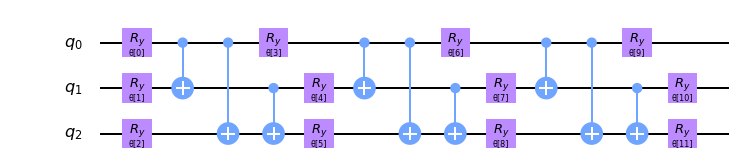

In [5]:
from qiskit.circuit.library import TwoLocal
rotation_blocks = ['ry']
entanglement_blocks = ['cx']
testAnsatz = TwoLocal(3, rotation_blocks, entanglement_blocks, 'full')
testAnsatz.draw(output='mpl')

**Example with a personalized circuit :**

In [6]:
from qiskit.circuit import Parameter
theta = Parameter('θ')

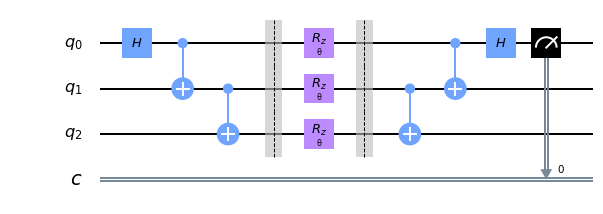

In [7]:
n = 3
qc = QuantumCircuit(n,1)
qc.h(0)
for i in range(n-1):
    qc.cx(i,i+1)
qc.barrier()
qc.rz(theta, range(n))
qc.barrier()
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)
qc.draw('mpl')

### 1.4 - Hamiltonian  <a name = 'qubitop'></a>

The hamiltonian, describing the problem, can be either created or is already implemented in Qiskit for several optimization problems. See [here](https://qiskit.org/documentation/apidoc/qiskit.optimization.applications.ising.html) for all ising models of optimization problems already implemented.  
For those already implemented, one can access the hamiltonian with the function `get_operator()`, returning the operator for the hamiltonian and a constant shift. 

Many things can be done with the `Operator` class, see [this tutorial](https://qiskit.org/documentation/tutorials/circuits_advanced/2_operators_overview.html) for explanation on how to create and manipulate such operators.

### 1.5 - Quantum instance  <a name = 'inst'></a>

A quantum instance allows to specify a backend and add configuration for the transpilation and the execution, such as the basis gates, the coupling map, backend options, noise model and many other options. See [here](https://qiskit.org/documentation/stubs/qiskit.aqua.QuantumInstance.html) for more details.

## 2 - Simple example over one qubit <a name = 'qubit'></a>

#### Definition of the problem
- Ansatz : the operator $R_y$:
    $$ R_y(\theta) = \begin{pmatrix} \cos(\theta/2) & -\sin(\theta/2) \\  \sin(\theta/2) & \cos(\theta/2) \end{pmatrix}$$
- Hamiltonian : the Pauli gate $Z$:
    $$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$
    This matrix has the eigenvalues $\{-1, +1\}$ respectively associated with the eigenvectors $\left\{ \begin{pmatrix} 0 \\ 1 \end{pmatrix}, \begin{pmatrix} 1 \\ 0 \end{pmatrix} \right\}$
- Optimizer : whatever we want in the Qiskit implementation.




#### Setting of all the entries required for VQE


##### Optimizer


In [8]:
optimizer = COBYLA(maxiter=500, tol=0.0001)

##### The hamiltonian, `qubitOp`
Here, we want to have the Pauli gate $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $.

In [9]:
qubitOp = Z
qubitOp

PauliOp(Pauli(z=[True], x=[False]), coeff=1.0)

##### Variational form

In [10]:
#Using one of the classes of Qiskit
var_form = TwoLocal(1,'ry',reps=1,insert_barriers=True, skip_final_rotation_layer=True)
print(var_form)

     ┌──────────┐ ░ 
q_0: ┤ RY(θ[0]) ├─░─
     └──────────┘ ░ 


In [11]:
#Creating a parameterized circuit
theta = Parameter('θ')
var_test = QuantumCircuit(1)
var_test.ry(theta,0)
var_test.barrier()
print(var_test)

     ┌───────┐ ░ 
q_0: ┤ RY(θ) ├─░─
     └───────┘ ░ 


#### The VQE instance

In [12]:
seed = 10598

backend = Aer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [13]:
vqe = VQE(qubitOp, var_test, optimizer)
vqe2 = VQE(qubitOp, var_form, optimizer)
vqe_run = vqe.run(quantum_instance)
vqe2_run = vqe2.run(quantum_instance)

exact = NumPyEigensolver(qubitOp)
exact_run = exact.run()

print('VQE with the ansatz TwoLocal\n',vqe2_run)
print('\nVQE with the parameterized ansatz\n',vqe_run)
print('\nExact eigensolver\n',exact_run)

VQE with the ansatz TwoLocal
 {'optimal_parameters': {Parameter(θ[0]): 3.1415036930460167}, 'optimal_point': array([3.14150369]), 'optimal_value': -0.99999999604301, 'optimizer_evals': 24, 'optimizer_time': 0.05338335037231445, 'eigenvalue': (-0.99999999604301+0j), 'eigenstate': array([4.44802719e-05+0.j, 9.99999999e-01+0.j]), 'cost_function_evals': 24}

VQE with the parameterized ansatz
 {'optimal_parameters': {Parameter(θ): 3.1415424402120986}, 'optimal_point': array([3.14154244]), 'optimal_value': -0.99999999873931, 'optimizer_evals': 23, 'optimizer_time': 0.07811212539672852, 'eigenvalue': (-0.99999999873931+0j), 'eigenstate': array([2.51066888e-05+0.j, 1.00000000e+00+0.j]), 'cost_function_evals': 23}

Exact eigensolver
 {'eigenvalues': array([-1.+0.j]), 'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 1.+0.j],
            dims=(2,)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)}


## 3 - The Max-Cut problem <a name = 'maxcut'></a>
### 3.1 - Introduction<a name = 'intro'></a>

Max-Cut is a well-known NP-complete optimization problem. Besides its theoretical importance, Max-Cut has applications in circuit layout design and statistical physics.

We formally define the Max-Cut problem as the following:  
We have a undirected graph $G = (V,E)$ with $|V| = n$ nodes, and each edge $ij \in E$ has a weight $w_{i,j} = w_{j,i} >0$. Weights over vertices $w_i$ can also be added.

A **cut** of a graph is a partition of the set $V$ in two subset $A,B$ such that $A \sqcup B = V$.  
**The cost** of the graph is defined here as the sum of all the weights of edges connecting the set A and the set B.

The optimization problem here is to **maximize the cost of all the edges connecting $A$ with $B$.**

<img src="cost.png" width = "400"/>

### 3.2 - Qiskit implementation<a name = 'qimp'></a>
#### Construct a 5 nodes graph and the corresponding weight matrix

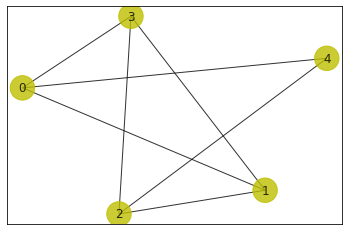

In [14]:
n=5 # Number of nodes in graph
G=nx.Graph() #Graph instance
G.add_nodes_from(np.arange(0,n,1)) #Set of nodes of the graph
e_list=[(0,1,1.0),(0,3,1.0),(0,4,1.0), (1,2,1.0),(1,3,1.), (2,3,1.0),(2,4,1.0)] #list of the edges of G with associated weight
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(e_list) #adding created edges to the graph

colors = ['y' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [15]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(i,n):
        edge = G.get_edge_data(i,j,default=0)
        if edge != 0:
            val = edge["weight"]
            w[i,j], w[j,i] = val, val
w

array([[0., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0.]])

##### Brute force approach

The idea is to assign a bit to each node of the graph, for example we assign 0 to the node if it is in set A, 1 if in set B. Then, we will test every bitstring of size 5 possible to find one with the greatest cost possible. Note that the solution we will find may not be unique, there may be several solutions reaching the maximal cost possible. It is mostly to see the maximum cost so we know if we reached it with the VQE instance.

This tests $2^n$ solutions, so 32 in this case meaning it can run without taking too much time, but this can quickly explode if the studied graph has many more nodes.

The best solution is = [1, 0, 1, 0, 0] with a cost = 6.0


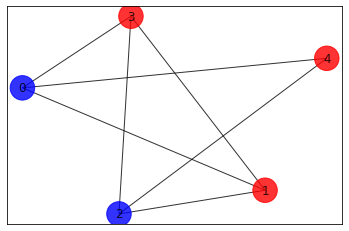

In [16]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('For the case = ' + str(x)+ ', we have this cost : ' + str(cost))
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('The best solution is = ' + str(xbest_brute) + ' with a cost = ' + str(best_cost_brute))    

##### Getting the operator specific to the Max-Cut problem from the matrix describing the graph

In [17]:
qubitOp, offset = max_cut.get_operator(w)
qubitOp, offset

(<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator at 0x1d8f0bbfdc0>,
 -3.5)

##### Checking the hamiltonian gives the right solution with the exact solver

energy: -2.5
max-cut objective: 6.0
solution: [1 0 1 0 0]
solution objective: 6.0


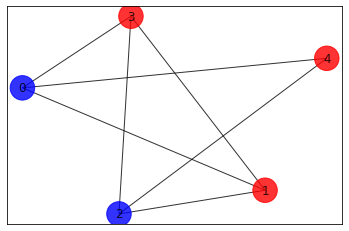

In [18]:
exact = NumPyEigensolver(qubitOp, k=1)
result = exact.run()

x = sample_most_likely(result['eigenstates'][0])
energy = min([i.real for i in result['eigenvalues']])
print('energy:', energy)
print('max-cut objective:', abs(energy + offset))
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

##### Running the VQE instance

In [19]:
seed = 10598

spsa = SPSA(max_trials=300)
var_form = TwoLocal(qubitOp.num_qubits,'ry',reps=1,insert_barriers=True, skip_final_rotation_layer=True)
vqe = VQE(qubitOp, var_form, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

energy: -2.49999992456674
time: 18.535477876663208
max-cut objective: 6.0
solution: [1 0 1 0 0]
solution objective: 6.0


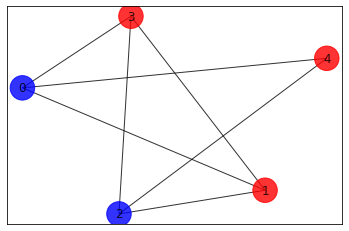

In [20]:
x = sample_most_likely(result['eigenstate'])
print('energy:', result['optimal_value'])
print('time:', result['optimizer_time'])
print('max-cut objective:',  abs(energy + offset))
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

## References

1. Jack D. Hidary, *Quantum Computing : an applied approach*, Springer 2019
2. Michael A. Nielsen and Isaac L. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press 2000
3. Qiskit textbook, [*Simulating Molecules using VQE*](https://qiskit.org/textbook/ch-applications/vqe-molecules.html)
4. Ronald de Wolf, *Quantum Computing : Lecture Notes*, arXiv:1907.09415v1 2019
5. Qiskit, [legacy tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/optimization/max_cut_and_tsp.ipynb)